In [202]:
# !rm -rf ./models
# !rm -rf /kaggle/working
# !rm ./*.mp4

In [177]:
import glob
import os
import shutil
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Video
import cv2
import json
import seaborn as sns
import requests
from tabulate import tabulate
from datetime import datetime
import pytz
from tqdm import tqdm
from concurrent.futures import *
import zipfile

timezone = pytz.timezone("Asia/Kolkata")
current_formatted_datetime = datetime.now(timezone).strftime("%d-%m-%y %H-%M-%S")
print(current_formatted_datetime)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

07-11-24 21-40-01
2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [53]:
def download_dataset():
    url = "https://storage.googleapis.com/kaggle-competitions-detached-data/16880/dfdc_train_part_48.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1731066047&Signature=qYpaUqbjztE68RAaZiHIUFOsmg2OEnN5yHLreuDnY4NuS4SIXLXaBrkgS1oQrm9ipuwoUyjsiRfL2ItfoOhMsU%2Fkc6VB7hR3kTnnLfk%2B1oSKXfKForrd5ZtE%2Bn1349Vu8EE11iySaJNB1Lno0uTzdZGgT%2FDIZ2oE5JEXg0ZItj8Gk22QdH5kioPmTXbHsExArhw90neYvZTR0N2J1279taE0Sj5M7PfQxETaIKWtXLDTbvkZvdWkRwHZuou7BCZuISjPeH8s67J%2Bn%2BjNaOHXdMowPMv7tEI4SzXEs3ZYvdK%2FK1wakKVpzWqLivUAsG491ZWl7ofkPn6NI8%2FFrYAouw%3D%3D"
    file_path = "dfdc_train_part_48.zip"

    # Send GET request to download the file
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    with open(file_path, "wb") as file:
        for chunk in tqdm(response.iter_content(chunk_size=8192), total=total_size//8192, unit="KB", desc="Downloading..."):
            file.write(chunk)
            
    zip_path = './dfdc_train_part_48.zip'
    out_dir = './dfdc_train_part_48'

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        total_files = len(zip_ref.infolist())
        for file in tqdm(zip_ref.infolist(), total=total_files, unit="file", desc="Extracting"):
            zip_ref.extract(file, out_dir)
            
    os.remove(file_path)
            
download_dataset()

Downloading...: 1184083KB [05:01, 3930.05KB/s]                             
Extracting: 100%|██████████| 2464/2464 [00:24<00:00, 102.51file/s]


In [62]:
def history_table(history):
    metrics = list(history.keys())
    num_epochs = len(history[metrics[0]])

    history_table = []
    for epoch in range(num_epochs):
        row = [epoch + 1] + [history[metric][epoch] for metric in metrics]
        history_table.append(row)

    print(tabulate(history_table, headers=["Epoch"] + metrics, tablefmt="grid"))
    
def plot_acc(history, name):
    plt.figure(figsize=(8, 5))
    plt.plot(history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history:
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

def plot_loss(history, name):
    plt.figure(figsize=(8, 5))
    plt.plot(history['loss'], label='Training Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    
def dump_json(data, name):
    with open(f"{name}.json", "w") as f:
        json.dump(data, f)
    print(f"Saved {name}.json")
    
def load_json(name):
    with open(f"{name}.json", "r") as f:
        return json.load(f)
    
def plot_model(model, name):
    return keras.utils.plot_model(model, to_file = f"{name}_structure_plot.png", show_shapes=True, show_layer_names = True)
    
def save_np(np_array, name):
    np.save(f"{name}.npy", np_array)
    
def load_np(name):
    return np.load(f"{name}.npy")

def save_pkl(sequence, name):
    with open(f"{name}.pkl", "wb") as f:
        pickle.dump(sequence, f)
        
def load_pkl(name):
    with open(f"{name}.pkl", "rb") as f:
        return pickle.load(f)
    
def move_files(file_paths, outdir):
    os.makedirs(outdir, exist_ok=True)
    for file_path in file_paths:
        # Extract filename and create new path
        filename = os.path.basename(file_path)
        new_path = os.path.join(outdir, filename)
        
        # Move file to new path
        shutil.move(file_path, new_path)
        
def move_and_update_path(path):
    if pd.notna(path):
        filename = os.path.basename(path)
        new_path = f'./test/{filename}'
        if os.path.exists(new_path):
            return new_path
        shutil.move(path, new_path)
        return new_path
    return np.nan


def move_all_files(src_folder, dest_folder):
    # Ensure the destination folder exists
    os.makedirs(dest_folder, exist_ok=True)
    
    # Iterate over each file in the source folder
    for filename in os.listdir(src_folder):
        file_path = os.path.join(src_folder, filename)
        
        # Move only if it's a file (skip directories)
        if os.path.isfile(file_path):
            shutil.move(file_path, os.path.join(dest_folder, filename))
    
def get_model_checkpoint(name):
    os.makedirs("models", exist_ok=True) 
    filepath = f"./models/DD_{name}" + "_epoch({epoch:02d})_acc({accuracy:.2f})_valacc({val_accuracy:.2f})_loss({loss:.2f})_valloss({val_loss:.2f})_" + f"{get_cdt()}.keras"
    model_checkpoint = keras.callbacks.ModelCheckpoint(filepath,
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        mode="max"
    )

    print(model_checkpoint.filepath)
    
    return model_checkpoint
    
def get_early_stopping(patience):
    early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",   
    patience=patience,              
    mode="max",               
    restore_best_weights=True
)
    return early_stopping

def get_cdt():
    return datetime.now(timezone).strftime("%d-%m-%y %H-%M-%S")

In [74]:
dataset_dir = "./dfdc_train_part_48/dfdc_train_part_48"
metadata_json = os.path.join(dataset_dir, "metadata.json")

print("Total videos: ",len(os.listdir(dataset_dir))-1)

print("metadata.json" in os.listdir(dataset_dir))

Total videos:  2463
True


In [81]:
metadata_df = pd.read_json(metadata_json).T
print(metadata_df.columns)
display(metadata_df)

Index(['label', 'split', 'original'], dtype='object')


,label,split,original
noagmcpxfb.mp4,FAKE,train,dgtdgrzifi.mp4
alzbizkswy.mp4,REAL,train,NaN
xcmkbpzfzw.mp4,FAKE,train,aoqzxlwvmi.mp4
uywdjgfgqr.mp4,FAKE,train,oupjhtodai.mp4
fbqwomdehr.mp4,FAKE,train,xtixietgjp.mp4
...,...,...,...
qzucqrxmaj.mp4,REAL,train,NaN
lbvpjkfemg.mp4,FAKE,train,oqehnuhbwa.mp4
drxswkgtst.mp4,REAL,train,NaN
oqehnuhbwa.mp4,REAL,train,NaN


In [78]:
# df.loc[:, 'video_file'] = df['video_file'].apply(lambda filename: os.path.join(dataset_dir, filename))
# df['original'] = df['original'].apply(
#     lambda filename: os.path.join(dataset_dir, filename) if pd.notna(filename) else filename
# )

In [79]:
# display(df)

label
FAKE    2041
REAL     422
Name: count, dtype: int64


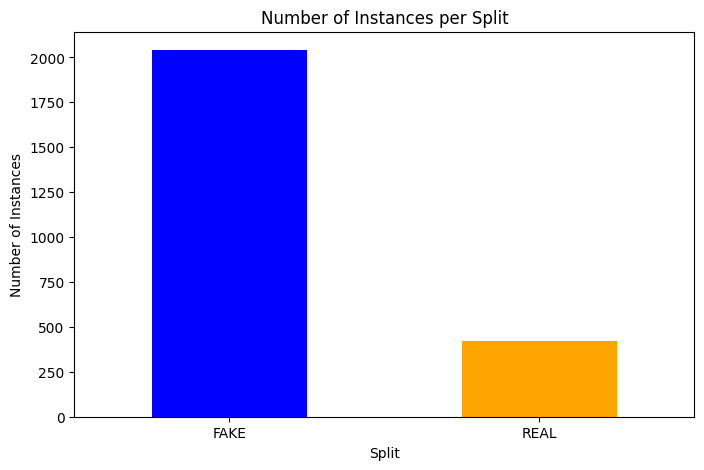

In [82]:
split_counts = metadata_df['label'].value_counts()

print(split_counts)

# Plotting the bar graph
plt.figure(figsize=(8, 5))
split_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Number of Instances per Split')
plt.xlabel('Split')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0) 
plt.show()

In [83]:
metadata_df.shape

(2463, 3)

In [95]:
loc = 2
real_video = os.path.join(dataset_dir,metadata_df["original"].iloc[loc])
fake_video = os.path.join(dataset_dir,metadata_df.index[loc])
Video(real_video, height=200, width=400)

In [96]:
Video(fake_video, height=200, width=400)

In [98]:
IMG_SIZE = 224
EPOCHS = 50

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [99]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y,x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    
    return frame[start_y : start_y+min_dim, start_x : start_x+min_dim]

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    
    try:
        while True:
            success, frame = cap.read()
            if not success:
                break
            
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2,1,0]]
            frames.append(frame)
            
            if len(frames) == max_frames:
                break
                
    except Exception as e:
        print(e)
        
    finally:
        cap.release()
        
    return np.array(frames)

def build_feature_extractor():
    feature_extractor = InceptionV3(
        weights = "imagenet",
        include_top = False,
        pooling = "avg",
        input_shape = (IMG_SIZE, IMG_SIZE, 3),
    )
    
    preprocess_input = inception_v3.preprocess_input
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)
    
    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor_iv3")

feature_extractor = build_feature_extractor()

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = list(df.index)
    labels = df["label"].values
    labels = np.array(labels=='FAKE').astype(int)
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
    
    for idx, path in enumerate(tqdm(video_paths)):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]
        
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH), dtype="bool")
        temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
        
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :], verbose=0)
            temp_frame_mask[i, :length] = 1
            
        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
                        
    return (frame_features, frame_masks), labels

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [102]:
Train_set , Test_set = train_test_split(metadata_df , test_size=0.2, random_state=42, stratify=metadata_df["label"])

In [103]:
print(Train_set.shape, Test_set.shape)

(1970, 3) (493, 3)


In [104]:
%%time
train_data, train_labels = prepare_all_videos(Train_set, "train")
test_data, test_labels = prepare_all_videos(Test_set, "test")

100%|██████████| 493/493 [00:00<00:00, 5481.05it/s]

CPU times: user 214 ms, sys: 234 ms, total: 448 ms
Wall time: 473 ms


In [105]:
print(f"Train labels shape: {train_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")


print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")


print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")

Train labels shape: (1970,)
Test labels shape: (493,)
Frame features in train set: (1970, 20, 2048)
Frame masks in train set: (1970, 20)
Frame features in test set: (493, 20, 2048)
Frame masks in test set: (493, 20)


In [112]:
def gru_model():
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))

    mask_input = keras.Input((MAX_SEQ_LENGTH, ), dtype="bool")
    x = GRU(64, return_sequences=True, use_cudnn=False)(frame_features_input, mask=mask_input)
    x = BatchNormalization()(x)
    x = GRU(32, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = GRU(16)(x)
    x = Dropout(0.5)(x) 
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.5)(x) 
    output = Dense(1, activation="sigmoid")(x)
    model = keras.Model([frame_features_input, mask_input], output,name="gru_model")
    
    return model

In [113]:
model = gru_model()

In [114]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "gru_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 20, 2048)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 20, 64)    │    405,888 │ input_layer_4[0]… │
│                     │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 64)    │        256 │ gru_3[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 20, 32)    │      9,408 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 32)    │        128 │ gru_4[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 16)        │      2,400 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16)        │          0 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        544 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 418,657 (1.60 MB)

 Trainable params: 418,465 (1.60 MB)

 Non-trainable params: 192 (768.00 B)

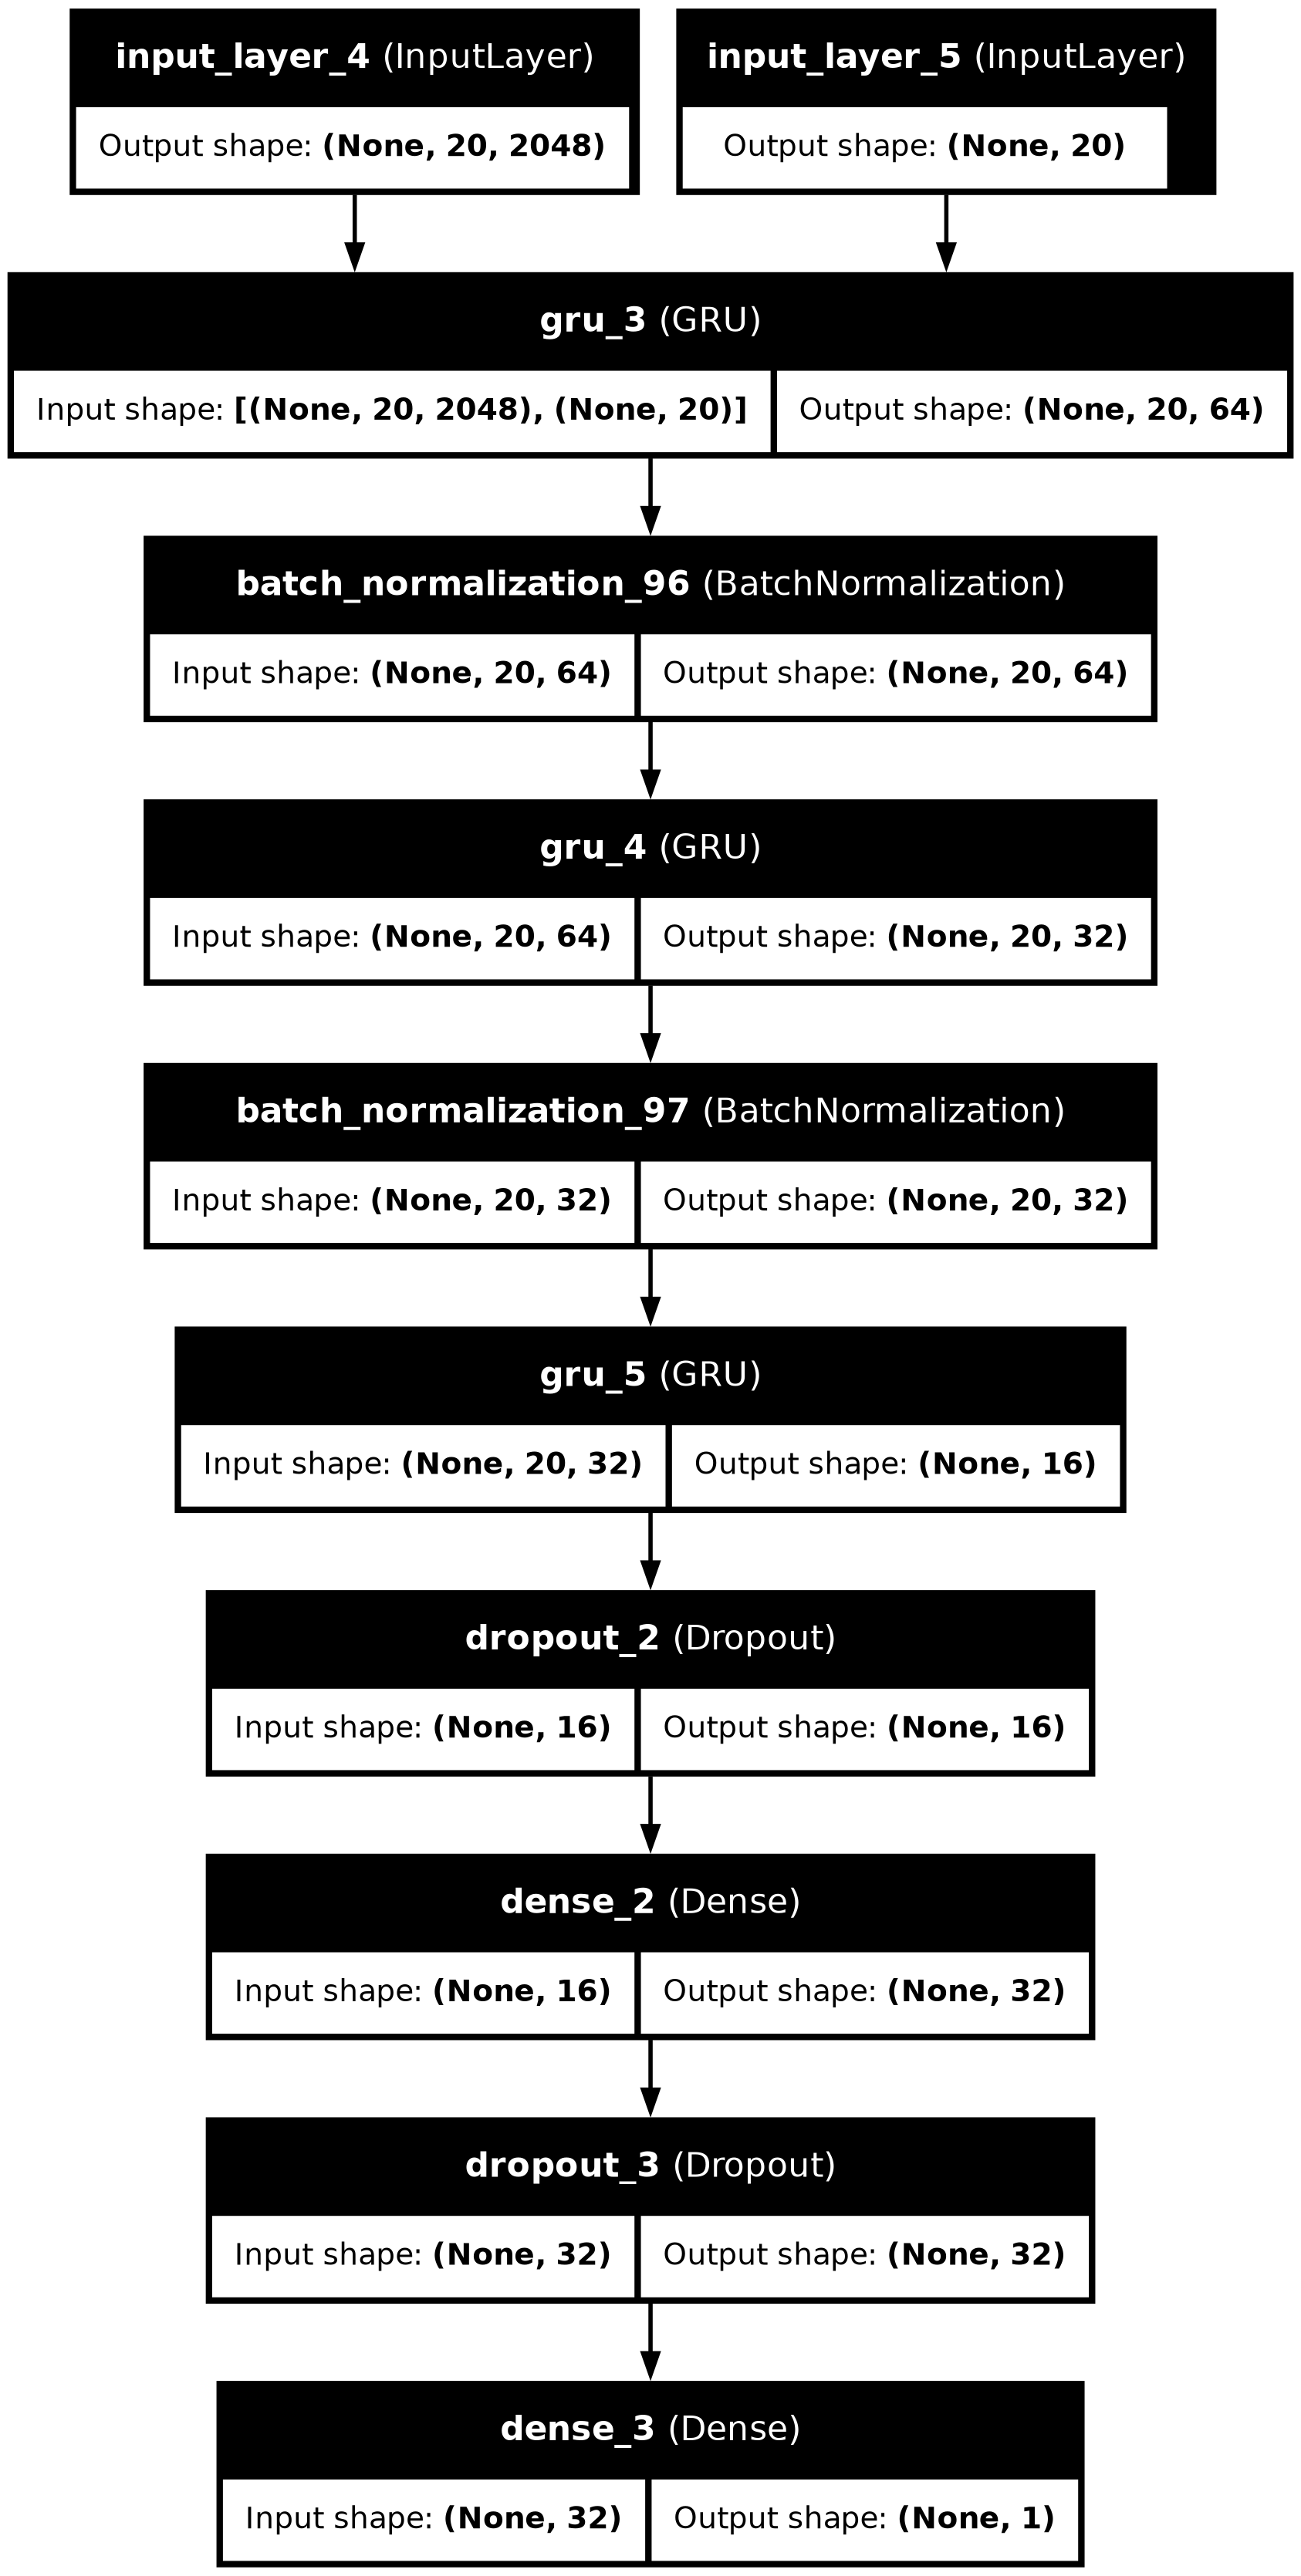

In [115]:
plot_model(model, "gru_model")

In [110]:
mc = get_model_checkpoint("gru_model")
es = get_early_stopping(20)

./models/DD_gru_model_epoch({epoch:02d})_acc({accuracy:.2f})_valacc({val_accuracy:.2f})_loss({loss:.2f})_valloss({val_loss:.2f})_07-11-24 20-23-07.keras


In [116]:
gru_history = model.fit(
    [train_data[0], train_data[1]],
    train_labels,
    validation_data=([test_data[0], test_data[1]], test_labels),
    callbacks=[mc, es],
    epochs=EPOCHS,
    batch_size=16
)

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8078 - loss: 0.6922
Epoch 1: val_accuracy improved from -inf to 0.82961, saving model to ./models/DD_gru_model_epoch(01)_acc(0.82)_valacc(0.83)_loss(0.69)_valloss(0.69)_07-11-24 20-23-07.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8079 - loss: 0.6922 - val_accuracy: 0.8296 - val_loss: 0.6893
Epoch 2/50
123/124 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8316 - loss: 0.6884
Epoch 2: val_accuracy did not improve from 0.82961
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8315 - loss: 0.6884 - val_accuracy: 0.8296 - val_loss: 0.6855
Epoch 3/50
123/124 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8051 - loss: 0.6852
Epoch 3: val_accuracy did not improve from 0.82961
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8054 - loss: 0.6852 - val_accuracy: 0.8296 - val_loss: 0.6817
Epoch 4/50
123/124 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8236 - loss: 0.6810
Epoch 4: val_accuracy 

In [117]:
dump_json(gru_history.history, "gru_history")

Saved gru_history.json


In [118]:
history = load_json("gru_history")

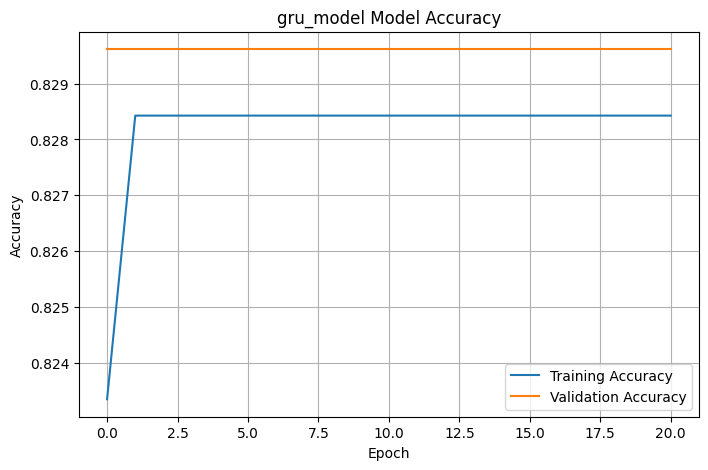

In [119]:
plot_acc(history, "gru_model")

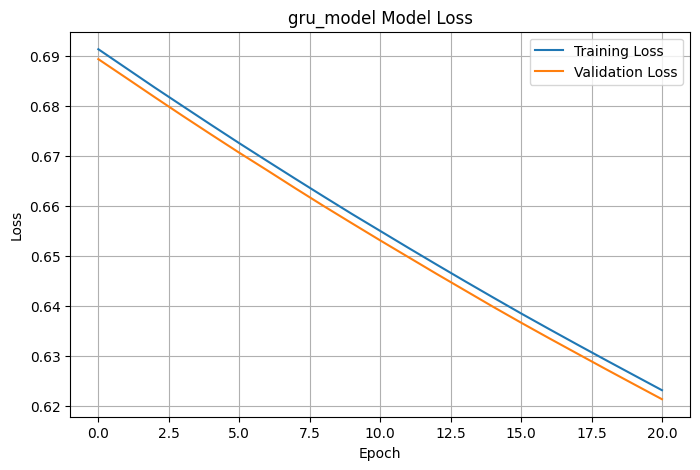

In [120]:
plot_loss(history, "gru_model")

In [121]:
history_table(history)

+---------+------------+----------+----------------+------------+
|   Epoch |   accuracy |     loss |   val_accuracy |   val_loss |
+=========+============+==========+================+============+
|       1 |   0.82335  | 0.691282 |       0.829615 |   0.689299 |
+---------+------------+----------+----------------+------------+
|       2 |   0.828426 | 0.687454 |       0.829615 |   0.685509 |
+---------+------------+----------+----------------+------------+
|       3 |   0.828426 | 0.683623 |       0.829615 |   0.681696 |
+---------+------------+----------+----------------+------------+
|       4 |   0.828426 | 0.679889 |       0.829615 |   0.677934 |
+---------+------------+----------+----------------+------------+
|       5 |   0.828426 | 0.676169 |       0.829615 |   0.67424  |
+---------+------------+----------+----------------+------------+
|       6 |   0.828426 | 0.672498 |       0.829615 |   0.670591 |
+---------+------------+----------+----------------+------------+
|       7 

In [122]:
history_df = pd.read_json("gru_history.json")
display(history_df)

,accuracy,loss,val_accuracy,val_loss
0,0.823350,0.691282,0.829615,0.689299
1,0.828426,0.687454,0.829615,0.685509
2,0.828426,0.683623,0.829615,0.681696
3,0.828426,0.679889,0.829615,0.677934
4,0.828426,0.676169,0.829615,0.674240
5,0.828426,0.672498,0.829615,0.670591
6,0.828426,0.668909,0.829615,0.667045
7,0.828426,0.665346,0.829615,0.663447
8,0.828426,0.661825,0.829615,0.659922
9,0.828426,0.658345,0.829615,0.656482


In [125]:
loss, accuracy = model.evaluate(test_data, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8140 - loss: 0.6895


In [181]:
loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)

predictions = model.predict(test_data, verbose=0)

predicted_labels = (predictions > 0.5).astype(int)

report = classification_report(test_labels, predicted_labels)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Loss: 0.6892991065979004
Accuracy: 0.8296145796775818
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.83      1.00      0.91       409

    accuracy                           0.83       493
   macro avg       0.41      0.50      0.45       493
weighted avg       0.69      0.83      0.75       493



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
sorted(os.listdir("models"))

['DD_gru_model_epoch(01)_acc(0.82)_valacc(0.83)_loss(0.69)_valloss(0.69)_07-11-24 20-23-07.keras']

In [168]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
    
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :], verbose=0)
        frame_mask[i, :length] = 1 # 1 = not masked, 0 = masked
    return frame_features, frame_mask

def sequence_prediction(path):
    frames = load_video(path)
    frame_features, frame_mask = prepare_single_video(frames)
    return model.predict([frame_features, frame_mask], verbose=0)[0]

In [133]:
print(Test_set['label'].value_counts()),display(Test_set)

label
FAKE    409
REAL     84
Name: count, dtype: int64


,label,split,original
zapvbcktlf.mp4,FAKE,train,likhvpxanp.mp4
hwtjiitwwe.mp4,FAKE,train,eqabuehals.mp4
obtflqoldv.mp4,REAL,train,NaN
knelidzqnj.mp4,FAKE,train,vsinqiaizy.mp4
alzbizkswy.mp4,REAL,train,NaN
...,...,...,...
msrspqaogq.mp4,FAKE,train,cefolmrrlx.mp4
wjjmpddtap.mp4,FAKE,train,lmbvoxhowe.mp4
iyheosista.mp4,FAKE,train,slakzltuxq.mp4
qywtzjmxlp.mp4,FAKE,train,cefolmrrlx.mp4


(None, None)

In [163]:
random_row = Test_set.sample()
random_video = os.path.join(dataset_dir,random_row.index[0])
random_video_label = random_row['label'].values[0]

print(f"Video : {random_video}\n Label : {random_video_label}")

prediction = sequence_prediction(random_video)
print(prediction)

if(prediction>=0.5):
    print('The predicted class of the video is FAKE')
else:
    print('The predicted class of the video is REAL')
          
Video(random_video, height=200, width=400)

Video : ./dfdc_train_part_48/dfdc_train_part_48/iyheosista.mp4
 Label : FAKE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[0.64057034]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
The predicted class of the video is FAKE


In [169]:
test_videos = list(Test_set.index.values)
test_video_paths = []
for video in test_videos:
    test_video_paths.append(os.path.join(dataset_dir, video))
    
# predictions = []

# for video_path in test_video_paths:
#     prediction = sequence_prediction(random_video)
#     predictions.append(np.round(prediction)) 

def get_rounded_prediction(video):
    prediction = sequence_prediction(video)
    return np.round(prediction)

with ThreadPoolExecutor() as executor:
    predictions = list(tqdm(executor.map(get_rounded_prediction, test_video_paths), 
                            total=len(test_video_paths), desc="Processing videos"))

Processing videos: 100%|██████████| 493/493 [16:17<00:00,  1.98s/it]


In [173]:
predictions = np.array(predictions)
num_ones = np.count_nonzero(predictions == 1.0)
num_zeros = np.count_nonzero(predictions == 0.0)

print(f"Fake predictions : {num_ones}")
print(f"Real predictions : {num_zeros}\n")

print(Test_set['label'].value_counts())

Fake predictions : 328
Real predictions : 165

label
FAKE    409
REAL     84
Name: count, dtype: int64


In [186]:
!pip install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.7 MB/s eta 0:00:0000:0100:01


In [211]:
%%capture
!yt-dlp -f 'bestvideo[ext=mp4]' -o '%(title)s.%(ext)s' 'https://www.youtube.com/watch?v=EcuBjya1EKs'
!yt-dlp -f 'bestvideo[ext=mp4]' -o '%(title)s.%(ext)s' 'https://www.youtube.com/watch?v=1GWNv4tsOWU'
!yt-dlp -f 'bestvideo[ext=mp4]' -o '%(title)s.%(ext)s' 'https://www.youtube.com/watch?v=vEupDz4ypqU'
!yt-dlp -f 'bestvideo[ext=mp4]' -o '%(title)s.%(ext)s' 'https://www.youtube.com/watch?v=KPw7-37B-vU'

In [208]:
video = "Ranbir Kapoor as Jon Snow in GOT [DeepFake].mp4"
label = "FAKE"

print(f"Video : {video}\n Label : {label}")

prediction = sequence_prediction(video)
print(prediction)

if(prediction>=0.5):
    print('The predicted class of the video is FAKE')
else:
    print('The predicted class of the video is REAL')
          
Video(video, height=450, width=800)

Video : Ranbir Kapoor as Jon Snow in GOT [DeepFake].mp4
 Label : FAKE
[0.5939476]
The predicted class of the video is FAKE


In [209]:
video = "Deepika Padukone as Wonder Woman [DeepFake].mp4"
label = "FAKE"

print(f"Video : {video}\n Label : {label}")

prediction = sequence_prediction(video)
print(prediction)

if(prediction>=0.5):
    print('The predicted class of the video is FAKE')
else:
    print('The predicted class of the video is REAL')
          
Video(video, height=450, width=800)

Video : Deepika Padukone as Wonder Woman [DeepFake].mp4
 Label : FAKE
[0.6019482]
The predicted class of the video is FAKE


In [210]:
video = "Hrithik Roshan as Bruce Wayne (Batman) [DeepFake].mp4"
label = "FAKE"

print(f"Video : {video}\n Label : {label}")

prediction = sequence_prediction(video)
print(prediction)

if(prediction>=0.5):
    print('The predicted class of the video is FAKE')
else:
    print('The predicted class of the video is REAL')
          
Video(video, height=450, width=800)

Video : Hrithik Roshan as Bruce Wayne (Batman) [DeepFake].mp4
 Label : FAKE
[0.5646154]
The predicted class of the video is FAKE


In [214]:
video = "Robert Downey Jr. on Being Cast as Iron Man (2007) ｜ #TBMTV.mp4"
label = "REAL"

print(f"Video : {video}\n Label : {label}")

prediction = sequence_prediction(video)
print(prediction)

if(prediction>=0.5):
    print('The predicted class of the video is FAKE')
else:
    print('The predicted class of the video is REAL')

Video : Robert Downey Jr. on Being Cast as Iron Man (2007) ｜ #TBMTV.mp4
 Label : REAL
[0.50293165]
The predicted class of the video is FAKE


[av1 @ 0x5892d1b6ccc0] Your platform doesn't suppport hardware accelerated AV1 decoding.
[av1 @ 0x5892d1b6ccc0] Failed to get pixel format.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Header.
[av1 @ 0x5892d1b6ccc0] Missing Sequence Head

In [215]:
Video(video, height=450, width=800)